In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import math

In [2]:
def load_files(initial_path, annot_path) :
    """Returns all the csv files' content in the form of DataFrame in a dict
    the initial annotations file (located at initial_path) is associated to the key "Init" in the dict
    the other files (located in the folder specified by annot_path) are respectivly associated to the part of their name that comes before the first '_' 
    """
    res = dict() 
    res["Init"] = pd.read_csv(init_path)
    for file in glob.glob(f"{annot_path}\\*.csv") :
        print(file)
        name = file.split('\\')[-1].split('_')[0]
        res[name] = pd.read_csv(file) 
    return res

In [3]:
init_path = "C:\\Users\\hfall\\Documents\\M1_TAL_IDMC\\Cours\\S7\\Projet\\annotation\\annot_24102024\\gold\\shuffled.csv"
annot_path = "C:\\Users\\hfall\\Documents\\M1_TAL_IDMC\\Cours\\S7\\Projet\\annotation\\annot_30102024"

# 'annotations' is dict that contains DataFrame as values
# one of those DataFrames is associated to the key "Init" -> it corresponds to the initial annotation provided in the dataset (intended sarcasm)
# the other values all correspond to the annotations provided by a different annotator (supposedly indicated as the key of the DataFrame in the dict)
annotations = load_files(init_path, annot_path) 

C:\Users\hfall\Documents\M1_TAL_IDMC\Cours\S7\Projet\annotation\annot_30102024\florian_30102024.csv
C:\Users\hfall\Documents\M1_TAL_IDMC\Cours\S7\Projet\annotation\annot_30102024\ivo_30102024.csv
C:\Users\hfall\Documents\M1_TAL_IDMC\Cours\S7\Projet\annotation\annot_30102024\Joely_311024.csv
C:\Users\hfall\Documents\M1_TAL_IDMC\Cours\S7\Projet\annotation\annot_30102024\maiwenn_27102024.csv
C:\Users\hfall\Documents\M1_TAL_IDMC\Cours\S7\Projet\annotation\annot_30102024\samba_28102024.csv
C:\Users\hfall\Documents\M1_TAL_IDMC\Cours\S7\Projet\annotation\annot_30102024\zsofia_30102024.csv


In [4]:
for annot, df in annotations.items() :
    print(f"{len(df)} annotations available for {annot}")

19941 annotations available for Init
999 annotations available for florian
999 annotations available for ivo
999 annotations available for Joely
999 annotations available for maiwenn
999 annotations available for samba
999 annotations available for zsofia


In [5]:
annotators = list(annotations.keys())
annotators.remove("Init") # obtained the list of all annotators by removing "Init" to the list of keys in the dict
annotators

['florian', 'ivo', 'Joely', 'maiwenn', 'samba', 'zsofia']

In [6]:
# the 'joined' dict contains all the DataFrame that were in the 'annotations' one (except for 'Init')
# A new column corresponding to the initial annotations (those in 'Init'), was added to all those DataFrames

joined = dict()
for ann in annotators :
    joined[ann] = annotations[ann].join( annotations["Init"][['ID', 'sarcastic']].set_index('ID'), on='ID' ) 

In [7]:
# 'annotated_ID' is another dict
# its keys are the annotators
# its values are the list of all the ID of the tweets the annotator annotated

annotated_ID = dict()
for ann, df in joined.items() :
    annotated_ID[ann] = list(df[~df["annotation"].isna()]["ID"])

In [8]:
# 'common_annotated_ids' is the set of all the IDs of the tweets that were annotated by everyone
# diffs stores the IDs that are exclusive to one annotator
common_annotated_ids = None
diffs = dict()
for ann, ids in annotated_ID.items() :
    if common_annotated_ids is None :
        common_annotated_ids = set(ids)
        diffs[ann] = set()
    else :
        previous = common_annotated_ids.copy()
        common_annotated_ids = common_annotated_ids.intersection(ids)
        diffs[ann] = previous.difference(common_annotated_ids)

# Displaying of diffs to make sure everyone annotated the same tweets
for ann, subset in diffs.items() :
    print(f"Difference for {ann} : {subset}")

Difference for florian : set()
Difference for ivo : set()
Difference for Joely : set()
Difference for maiwenn : set()
Difference for samba : set()
Difference for zsofia : set()


In [9]:
# 'joined_limited' is a new dict
# it contains all the DataFrames in 'joined', but restricted to the tweets that were annotated by everyone
joined_limited = dict()
for ann, df in joined.items() :
    joined_limited[ann] = df[ df['ID'].isin(common_annotated_ids) ]

In [10]:
for df in joined_limited.values() :
    print(f"Everyone annotated {len(df)} tweets")

Everyone annotated 999 tweets
Everyone annotated 999 tweets
Everyone annotated 999 tweets
Everyone annotated 999 tweets
Everyone annotated 999 tweets
Everyone annotated 999 tweets


In [11]:
def weight(annot_tag, init_tag) :
    """
    Returns the weights (= the matching score) between a tag in the scale used for the annotation (0,  0.25, 0.5, 0.75, 1) and the initial tagset (0, 1)
    """
    return 1 - abs(annot_tag - init_tag)

In [12]:
# We had some issues about spreadsheets writing decimal numbers with . or , as a dot
# Python can automatically deal with them when written with . but not with ,
# This function is here to make sure all the values in the DataFrames are written correctly
def tag_to_float(tag) :
    try :
        return float(tag)
    except :
        clean_tag = str(tag).replace(",", ".")
        return float(clean_tag)

In [13]:
# put all the tag in the right format to be handled by Python
for df in joined_limited.values() :
    df.loc[:, "annotation"] = df["annotation"].apply(tag_to_float)

In [14]:
def weighted_kappa(df_limited, display_confusion=True) :
    init_tags = list(set(df_limited["sarcastic"])) # the initial tags
    annot_tags = list(set(df_limited["annotation"])) # the tags provided by the annotator

    # creating the confusion matrix
    mat = np.zeros( (len(init_tags), len(annot_tags)) )                  
    for idx, row in df_limited.iterrows() :
        init = init_tags.index(row["sarcastic"])
        annot = annot_tags.index(row["annotation"])
        mat[init][annot] += 1
    
    a0 = 0
    ae = 0
    total = len(df_limited)

    # prints the confusion matrix
    if display_confusion :
        print(f"row tags : {init_tags}")
        print(f"columns tags : {annot_tags}")
        print(mat)
        print("--------------")

    # contains the number of occurrences for all the tags 
    sums = { "init" : dict() , "annot" : dict() }

    # do the calculations of the weighted kappa
    for init_idx, init_tag in enumerate(init_tags) :
        sums["init"][init_tag] = mat[init_idx].sum()
        for annot_idx, annot_tag in enumerate(annot_tags) :
            if annot_tag not in sums["annot"] :
                sums["annot"][annot_tag] = sum([x[annot_idx] for x in mat])
            a0 += weight(annot_tag, init_tag) * mat[init_idx][annot_idx] / total
            ae += weight(annot_tag, init_tag) * sums["init"][init_tag] * sums["annot"][annot_tag] / (total * total)
    
    kappa = (a0 - ae) / (1 - ae)
    return {"kappa" : kappa, "Ao" : a0}
        

In [15]:
def all_sorted(* lists, reverse=False) :
    """
    Takes as an input some lists
    Sorts the first list, and apply the same order in the other lists
    For example, if there is three lists :
    - A containing marks : A = [15, 18, 12]
    - B containing names : B = ["Margote", "Zebulon", "Pollux"]
    - C containing ages : C = [13, 110, 51]
    The first list is sorted : A gives [12, 15, 18]
    The other lists are shuffled in a way such that the i-th element in one list goes to the j-th position 
    if the i-th element in A went in the j-th position during the sorting
    So B and C give : ["Pollux", "Margote", "Zebulon"] and [51, 13, 110]
    All the original lists remain unchanged : they are all copied during the process
    """
    master = lists[0].copy()
    sorted_master = lists[0].copy()
    sorted_master.sort(reverse=reverse)
    old_idxs = []
    for idx, val in enumerate(sorted_master) :
        deb = 0
        old_idx = master[deb:].index(val)
        while old_idx in old_idxs :
            deb = old_idx + 1
            old_idx = master[deb:].index(val)
        old_idxs.append(old_idx)
    return ([l[idx] for idx in old_idxs] for l in lists)
        
    

florian
row tags : [0, 1]
columns tags : [0.0, 1.0, 0.25, 0.5, 0.75]
[[451.   3.   9.  21.   8.]
 [277.  97.  24.  57.  52.]]
--------------
ivo
row tags : [0, 1]
columns tags : [0.0, 0.25, 0.5, 0.75, 1.0]
[[402.  35.  43.   5.   7.]
 [171.  43.  76.  63. 154.]]
--------------
Joely
row tags : [0, 1]
columns tags : [0.75, 0.0, 0.25, 0.5, 1.0]
[[ 44. 325.  51.  56.  16.]
 [ 78. 180.  24.  58. 167.]]
--------------
maiwenn
row tags : [0, 1]
columns tags : [0.25, 0.0, 1.0, 0.75, 0.5]
[[ 69. 358.  14.  21.  30.]
 [ 41. 160. 172.  72.  62.]]
--------------
samba
row tags : [0, 1]
columns tags : [0.0, 0.25, 0.75, 0.5, 1.0]
[[348.  89.  21.  30.   4.]
 [148.  81. 120.  63.  95.]]
--------------
zsofia
row tags : [0, 1]
columns tags : [0.25, 0.0, 0.5, 0.75, 1.0]
[[161. 227.  48.  28.  28.]
 [ 81.  36.  76.  67. 247.]]
--------------


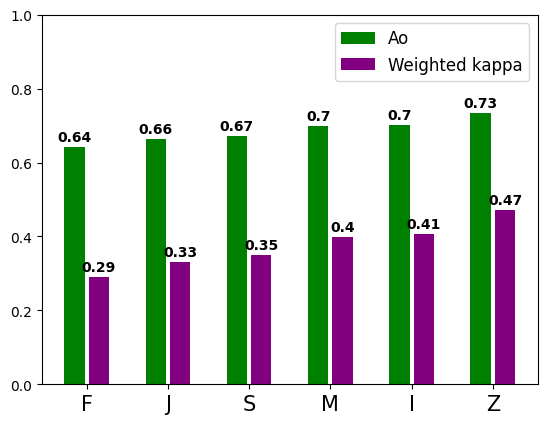

In [16]:
# Displaying plots
keys = []
aos = []
kappas = []
for key, df_limited in joined_limited.items() :
    print(key)
    res = weighted_kappa(df_limited)
    keys.append(key)
    aos.append(res["Ao"])
    kappas.append(res["kappa"])

kappas, aos, keys = all_sorted(kappas, aos, keys)

x = np.array(range(len(keys)))
bar = plt.bar(x - 0.15, aos, width=0.25, label="Ao", color="green")
plt.bar_label(bar, labels=[round(x,2) for x in aos], padding=2, weight='bold')
bar = plt.bar(x + 0.15, kappas, width=0.25, label="Weighted kappa", color="purple")
plt.bar_label(bar, labels=[round(x,2) for x in kappas], padding=2, weight='bold')
plt.xticks(x, [x[0].upper() for x in keys], fontsize=15)
plt.ylim([0,1])
plt.legend(prop={'size':12})
plt.show()


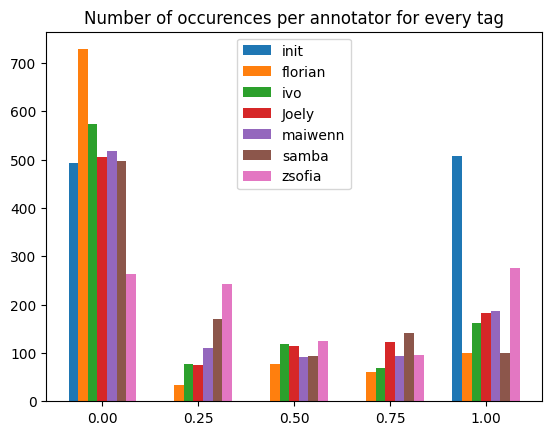

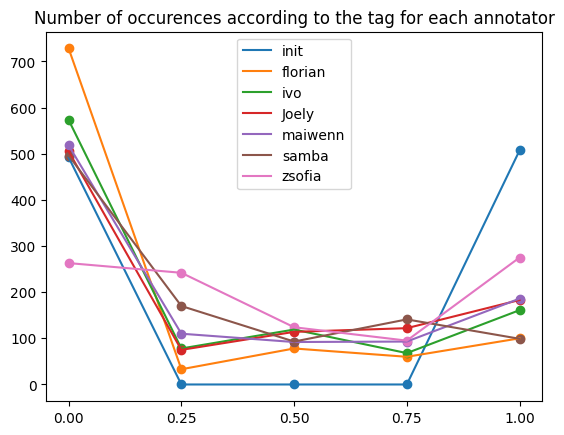

In [17]:
# Other plots

counts = dict()
tags = set()
counts["init"] = [ tag_to_float(x) for x in list(joined_limited.values())[0]["sarcastic"] ]
for annot, df in joined_limited.items() :
    counts[annot] = list(df["annotation"])
    tags = tags.union(set(counts[annot]))

tags = list(tags)
tags.sort()

counts = { k : [v.count(x) for x in tags] for k,v in counts.items()  }

nb_cat = len(tags)
nb_data = len( list(joined_limited.values())[0] )
gap = min( [val - tags[idx] for idx, val in enumerate(tags[1:]) ] ) 
width = gap / (2 * nb_cat)
xvals = np.array(tags, float) - (((nb_cat / 2) + 0.5) * width)
for annot, count in counts.items() :
    plt.bar(xvals, count, width=width, label=annot)
    xvals = xvals + width
plt.xticks(tags)
plt.title("Number of occurences per annotator for every tag")
plt.legend()
plt.show()

for annot, count in counts.items() :
    plt.scatter( tags, count)
    plt.plot( tags, count, label=annot )
plt.xticks(tags)
plt.legend()
plt.title("Number of occurences according to the tag for each annotator")
plt.show()


# Investigation

## By dataset

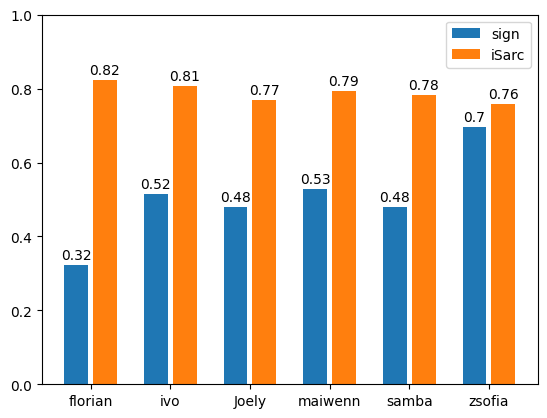

In [52]:
sources = annotations["Init"]["original_ID"].apply( (lambda x : "iSarc" if x[:4] != "sign" else x[:4] ) ).to_frame().join(annotations["Init"]["ID"])
sources = sources.rename(columns = {"original_ID" : "source"})

avg_scores_per_dataset = dict()
for annot, df in joined_limited.items() :
    avg_scores_per_dataset[annot] = {"sign" : [], "iSarc" : []}
    for idx, row in df.iterrows() :
        source = sources[ sources['ID'] == row['ID'] ]["source"]
        if len(source) != 1 :
            raise ValueError("Problem here")
        source = list(source)[0]
        avg_scores_per_dataset[annot][source].append(  weight(row["annotation"], row["sarcastic"]) )

    for s in avg_scores_per_dataset[annot].keys():    
        avg_scores_per_dataset[annot][s] = sum( avg_scores_per_dataset[annot][s] ) / len( avg_scores_per_dataset[annot][s] )

xTicks = list(avg_scores_per_dataset.keys())

bar = plt.bar( np.array(range(0, len(xTicks))) - 0.18, [ avg_scores_per_dataset[a]["sign"] for a in xTicks ], width=0.3, label="sign" )
plt.bar_label(bar, labels=[ round(avg_scores_per_dataset[a]["sign"],2) for a in xTicks ] , padding=2 )
bar = plt.bar( np.array(range(0, len(xTicks))) + 0.18, [ avg_scores_per_dataset[a]["iSarc"] for a in xTicks ], width=0.3, label="iSarc" )
plt.bar_label(bar, labels=[ round(avg_scores_per_dataset[a]["iSarc"],2) for a in xTicks ] , padding=2 )
plt.legend()
plt.xticks(range(0, len(xTicks)), xTicks)
plt.ylim([0,1])
plt.show()
    


## Over time 

In [101]:
def avg_vals(vals, sensibility, normalized=False) :
    gap = int(math.floor(sensibility / 2))
    res = []
    for idx, val in enumerate(vals) :
        beg = max(0, idx - gap)
        end = min(len(vals), idx + gap + 1)
        res.append( sum(vals[beg:end]) / (end - beg) )
    if normalized :
        min_val = min(res)
        max_val = max(res)
        res = [(x - min_val) / (max_val - min_val) for x in res]
    return res

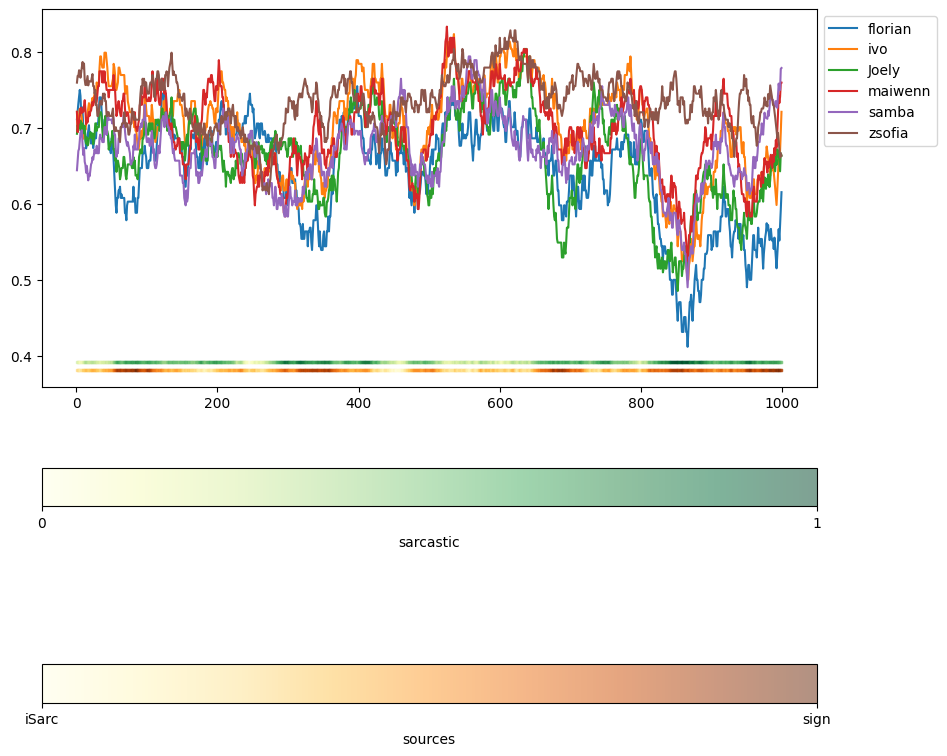

In [196]:
sensibility = 51


fig, ax = plt.subplots(figsize=(10, 10))

min_val = 1

for annot, df in joined_limited.items() :
    scores = [ weight(row["annotation"], row["sarcastic"]) for idx, row in df.iterrows() ]
    avg_scores = avg_vals(scores, sensibility)
    min_val = min( [min_val, min(avg_scores)] )
    ax.plot( range(1, len(scores) + 1), avg_scores, label= annot)

sorted_sources = []
for idx, row in list(joined_limited.values())[0].iterrows() :
    sorted_sources.append( list(sources[ sources['ID'] == row['ID'] ]["source"])[0]  )

source_to_num = {"sign" : 1 , "iSarc" : 0}

sorted_sources_num = [ source_to_num[x] for x in sorted_sources ]

avg_sorted_sources_num = avg_vals(sorted_sources_num, sensibility,normalized=True)

sc_source = ax.scatter( range(1, len(scores) + 1), [min_val-0.03] * len(scores), c=avg_sorted_sources_num, marker="s", s=2, alpha=0.5, cmap="YlOrBr") 
cbar = fig.colorbar(sc_source, ax=ax, orientation='horizontal', label='sources', ticks=[0, 1])
cbar.ax.set_xticklabels(["iSarc", "sign"])
sorted_initial_annotations = list( list(joined_limited.values())[0]["sarcastic"] )
avg_sorted_initial_annotations = avg_vals(sorted_initial_annotations, sensibility, normalized=True)
sc_sarc = ax.scatter (range(1, len(scores) + 1), [min_val-0.02] * len(scores), c=avg_sorted_initial_annotations,marker="s", s=2, alpha=0.5, cmap="YlGn") 
cbar = fig.colorbar(sc_sarc, ax=ax, orientation='horizontal', label='sarcastic', ticks=[0,1])


"""  
axs[0].set_title(f"Evolution of scores over time")
axs[1].set_title("Proposition of tweets according to their sources over time")
axs[2].set_title("Proposition of 'sarcastic' tweet over time")
axs[2].set_ylim([0,1])
axs[1].set_yticks( list(source_to_num.values()) , list(source_to_num.keys()) )
"""
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()        

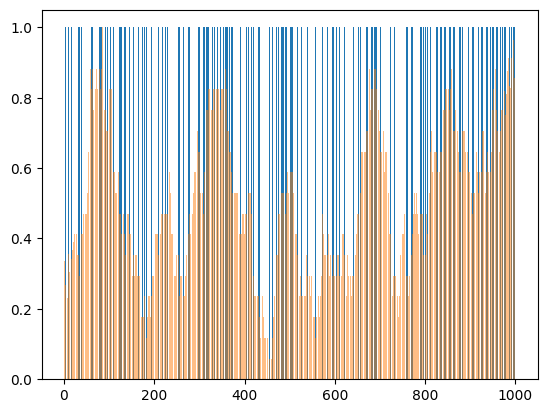

In [191]:
plt.bar(range(1, len(sorted_sources_num) + 1),sorted_sources_num)
plt.bar(range(1, len(sorted_sources_num) + 1),avg_sorted_sources_num, alpha=0.5)
plt.show()

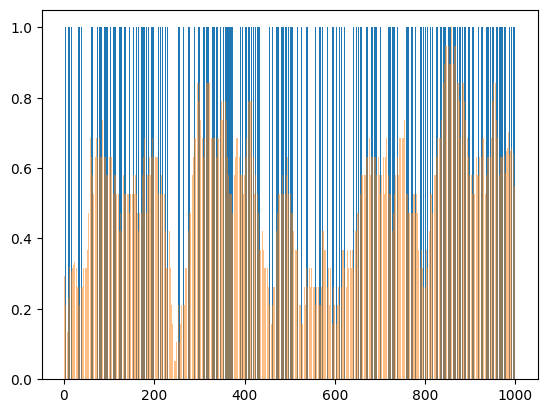

In [192]:
plt.bar(range(1, len(sorted_initial_annotations) + 1),sorted_initial_annotations)
plt.bar(range(1, len(sorted_initial_annotations) + 1), avg_sorted_initial_annotations, alpha=0.5)
plt.show()

## By 0/1

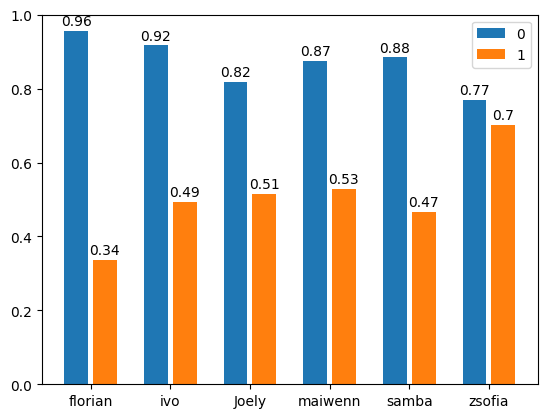

In [194]:
avg_scores_per_sarc = dict()
for annot, df in joined_limited.items() :
    avg_scores_per_sarc[annot] = {0 : [], 1 : []}
    for idx, row in df.iterrows() :
        sarc = row["sarcastic"]
        avg_scores_per_sarc[annot][sarc].append(  weight(row["annotation"], row["sarcastic"]) )

    for s in avg_scores_per_sarc[annot].keys():    
        avg_scores_per_sarc[annot][s] = sum( avg_scores_per_sarc[annot][s] ) / len( avg_scores_per_sarc[annot][s] )

xTicks = list(avg_scores_per_sarc.keys())

bar = plt.bar( np.array(range(0, len(xTicks))) - 0.18, [ avg_scores_per_sarc[a][0] for a in xTicks ], width=0.3, label=0 )
plt.bar_label(bar, labels=[ round(avg_scores_per_sarc[a][0],2) for a in xTicks ] , padding=2 )
bar = plt.bar( np.array(range(0, len(xTicks))) + 0.18, [ avg_scores_per_sarc[a][1] for a in xTicks ], width=0.3, label=1 )
plt.bar_label(bar, labels=[ round(avg_scores_per_sarc[a][1],2) for a in xTicks ] , padding=2 )
plt.legend()
plt.xticks(range(0, len(xTicks)), xTicks)
plt.ylim([0,1])
plt.show()